In [1]:
if 'google.colab' in str(get_ipython()):
    GITHUB_TOKEN = ""
    !rm -rf anti_money_laundering
    !git clone https://{GITHUB_TOKEN}@github.com/FedericoBruzzone/anti_money_laundering.git
    !mv anti_money_laundering/* 
    !rm -rf anti_money_laundering

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

import time
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from src.utils.kaggle_config            import setup_kaggle
from src.utils.kaggle_config            import download_dataset

from src.utils.datasets_handler         import (get_train_and_test,
                                                get_X_and_Y,
                                                print_dataset,
                                                label_encoder,
                                                split_timestamp)
from src.utils.performance_measures     import calculate_performances
from src.utils.plot_measures            import (plot_correlation_matrix,  
                                                plot_numerical_histograms, 
                                                plot_roc_curve,
                                                plot_confusion_matrix)
from src.utils.dataset_sampling_methods import (oversampling,
                                                undersampling,
                                                bootstrap_sampling)

from src.decision_tree.decision_tree    import CustomDecisionTree
from src.decision_tree.ID3              import DecisionTreeID3
from src.decision_tree.C45              import DecisionTreeC45
from src.decision_tree.entropy_type     import EntropyType
from src.decision_tree.criterion_type   import CriterionType

from IPython.display import Image, display

VERBOSE = int(os.getenv('VERBOSE'))
VIEW = os.getenv('VIEW')

setup_kaggle()
print("---------------------- Downloading dataset ----------------------") 
download_dataset("iammustafatz/diabetes-prediction-dataset")
download_dataset("ealtman2019/ibm-transactions-for-anti-money-laundering-aml")
print("---------------------- End downloading dataset ----------------------")

hi_small_trans = "HI-Small_Trans.csv"
diabetes = "diabetes_prediction_dataset.csv"

---------------------- Downloading dataset ----------------------
---------------------- End downloading dataset ----------------------


## Preliminary test: Diabetes Dataset

In [3]:
df_train, df_test = get_train_and_test(diabetes, verbose=VERBOSE)
X_train, y_train = get_X_and_Y(df_train, verbose=VERBOSE)
X_test, y_test = get_X_and_Y(df_test, verbose=VERBOSE)
X_train, _ = label_encoder(X_train, ['gender', 'smoking_history'])
X_test,  _ = label_encoder(X_test, ['gender', 'smoking_history'])

### ID3

In [4]:
print("---------------------- ID3 --------------------------")    
start_time = time.time()
decision_tree: DecisionTreeID3 = DecisionTreeID3(max_depth=10, 
                                                    num_thresholds_numerical_attr=6)
decision_tree.fit(X_train, y_train)
end_time = time.time()
decision_tree.create_dot_files(filename="tree-id3-diabetes", generate_png=True, view="")
print()
print("Performances: ")
predictions = list(decision_tree.predict_test(X_test))
print(f"Fit time: {end_time - start_time} seconds") 
calculate_performances(predictions, y_test, "id3", verbose=True)
print("-------------------------- END ID3 --------------------------")

---------------------- ID3 --------------------------
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 6


Performances: 
Fit time: 2.4090232849121094 seconds
    F1 score: 0.547981     Accuracy: 0.947950
   Precision: 1.000000       Recall: 0.377392
          TP:      631           TN:    18328
          FP:        0           FN:     1041
         TPR: 0.377392          FPR: 0.000000
-------------------------- END ID3 --------------------------


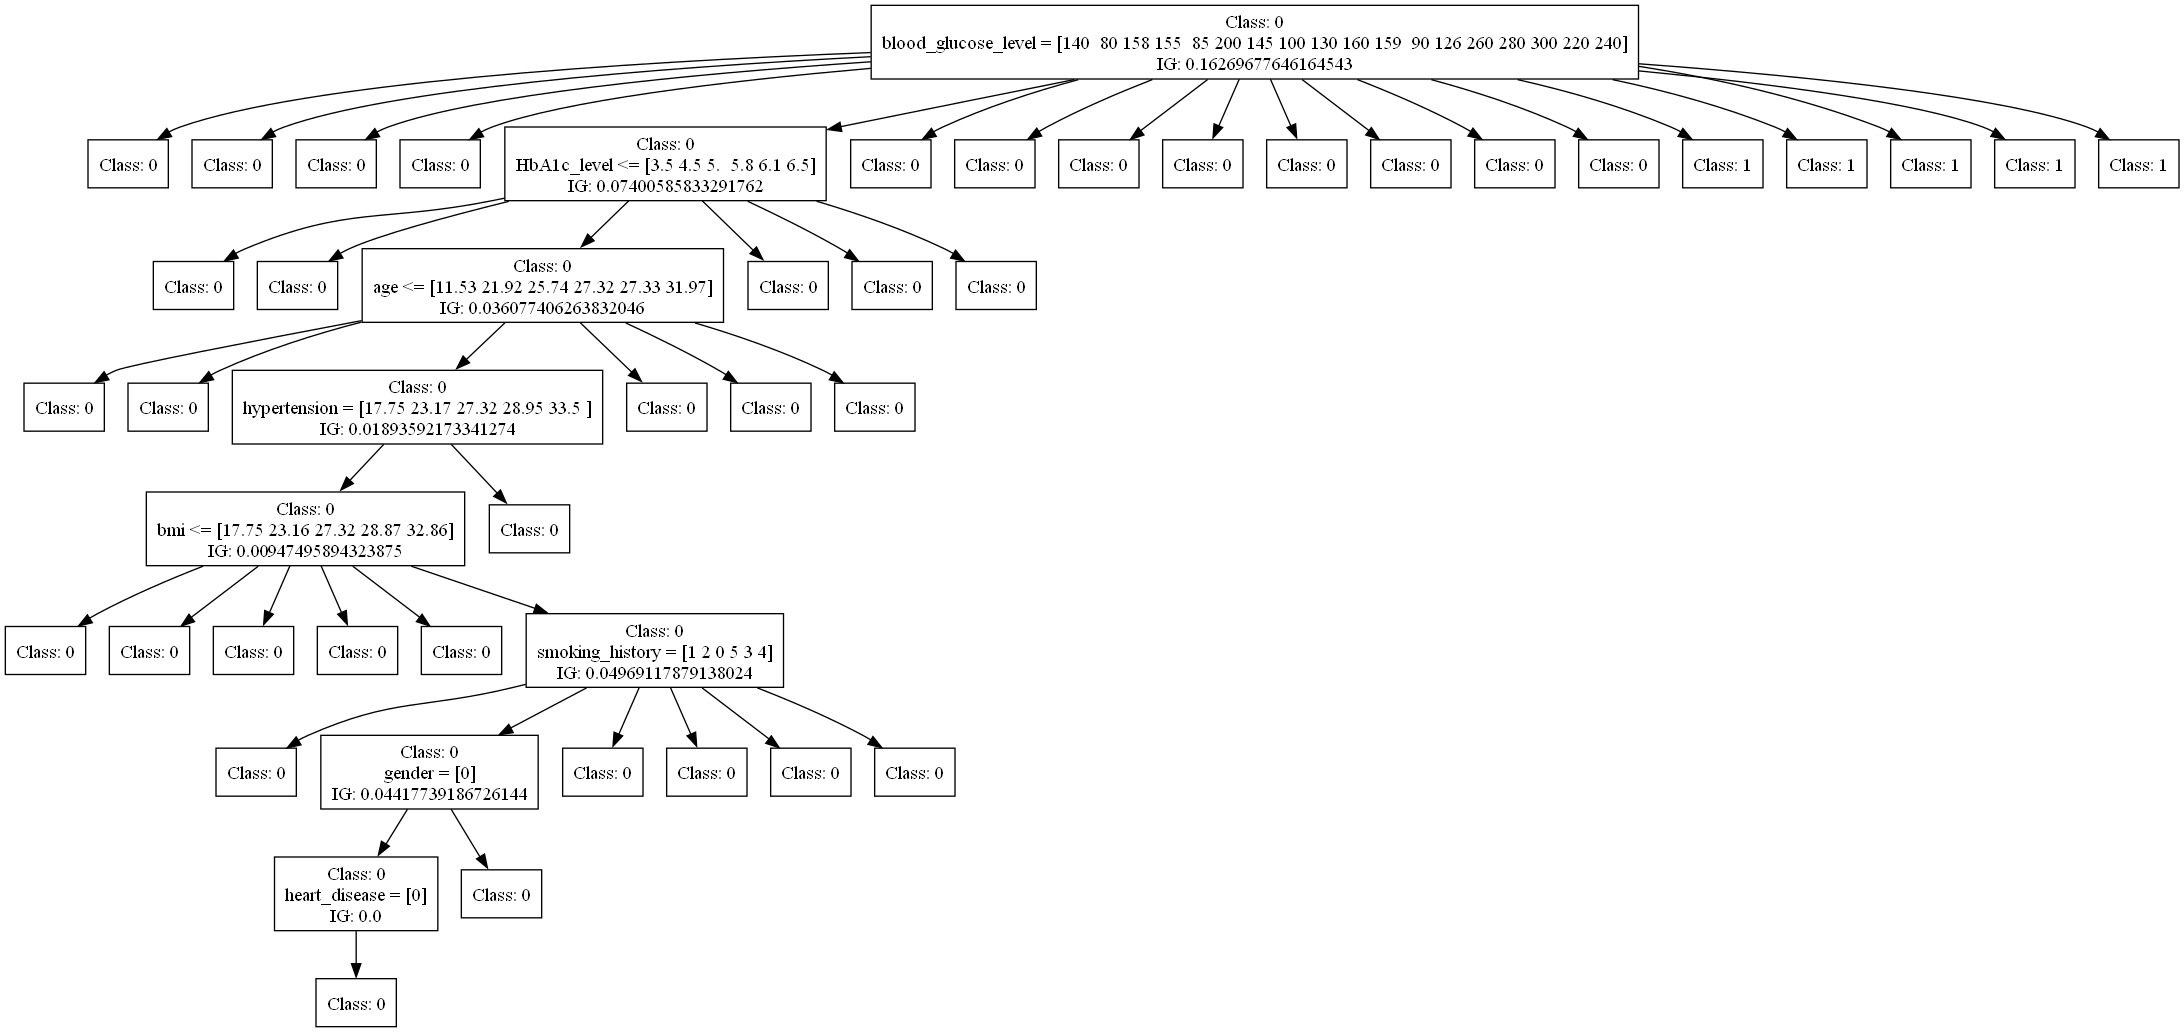

In [5]:
display(Image(filename='./dot_figs/tree-id3-diabetes.png'))

### Custom

In [6]:
print("-------------------------- CUSTOM --------------------------")
start_time = time.time()
decision_tree = CustomDecisionTree(criterion=EntropyType.SHANNON, 
                                    type_criterion=CriterionType.BEST, 
                                    max_depth=10, 
                                    min_samples_split=20,
                                    num_thresholds_numerical_attr=6)
decision_tree.fit(X_train, y_train)
end_time = time.time()
decision_tree.create_dot_files(filename="tree-custom-diabetes", generate_png=True, view="")
print()
print("Performances: ") 
predictions = list(decision_tree.predict_test(X_test))
print(f"Fit time: {end_time - start_time} seconds")
calculate_performances(predictions, y_test, "custom", verbose=True)
print("-------------------------- END CUSTOM --------------------------")

-------------------------- CUSTOM --------------------------
PARAMETERS:
	CRITERION: Entropy
	TYPE CRITERION: Best
	MAX DEPTH: 10
	MIN SAMPLES SPLIT: 20
	NUM THRESHOLDS NUMERICAL ATTR: 6


Performances: 
Fit time: 23.02033495903015 seconds
    F1 score: 0.796256     Accuracy: 0.971700
   Precision: 1.000000       Recall: 0.661483
          TP:     1106           TN:    18328
          FP:        0           FN:      566
         TPR: 0.661483          FPR: 0.000000
-------------------------- END CUSTOM --------------------------


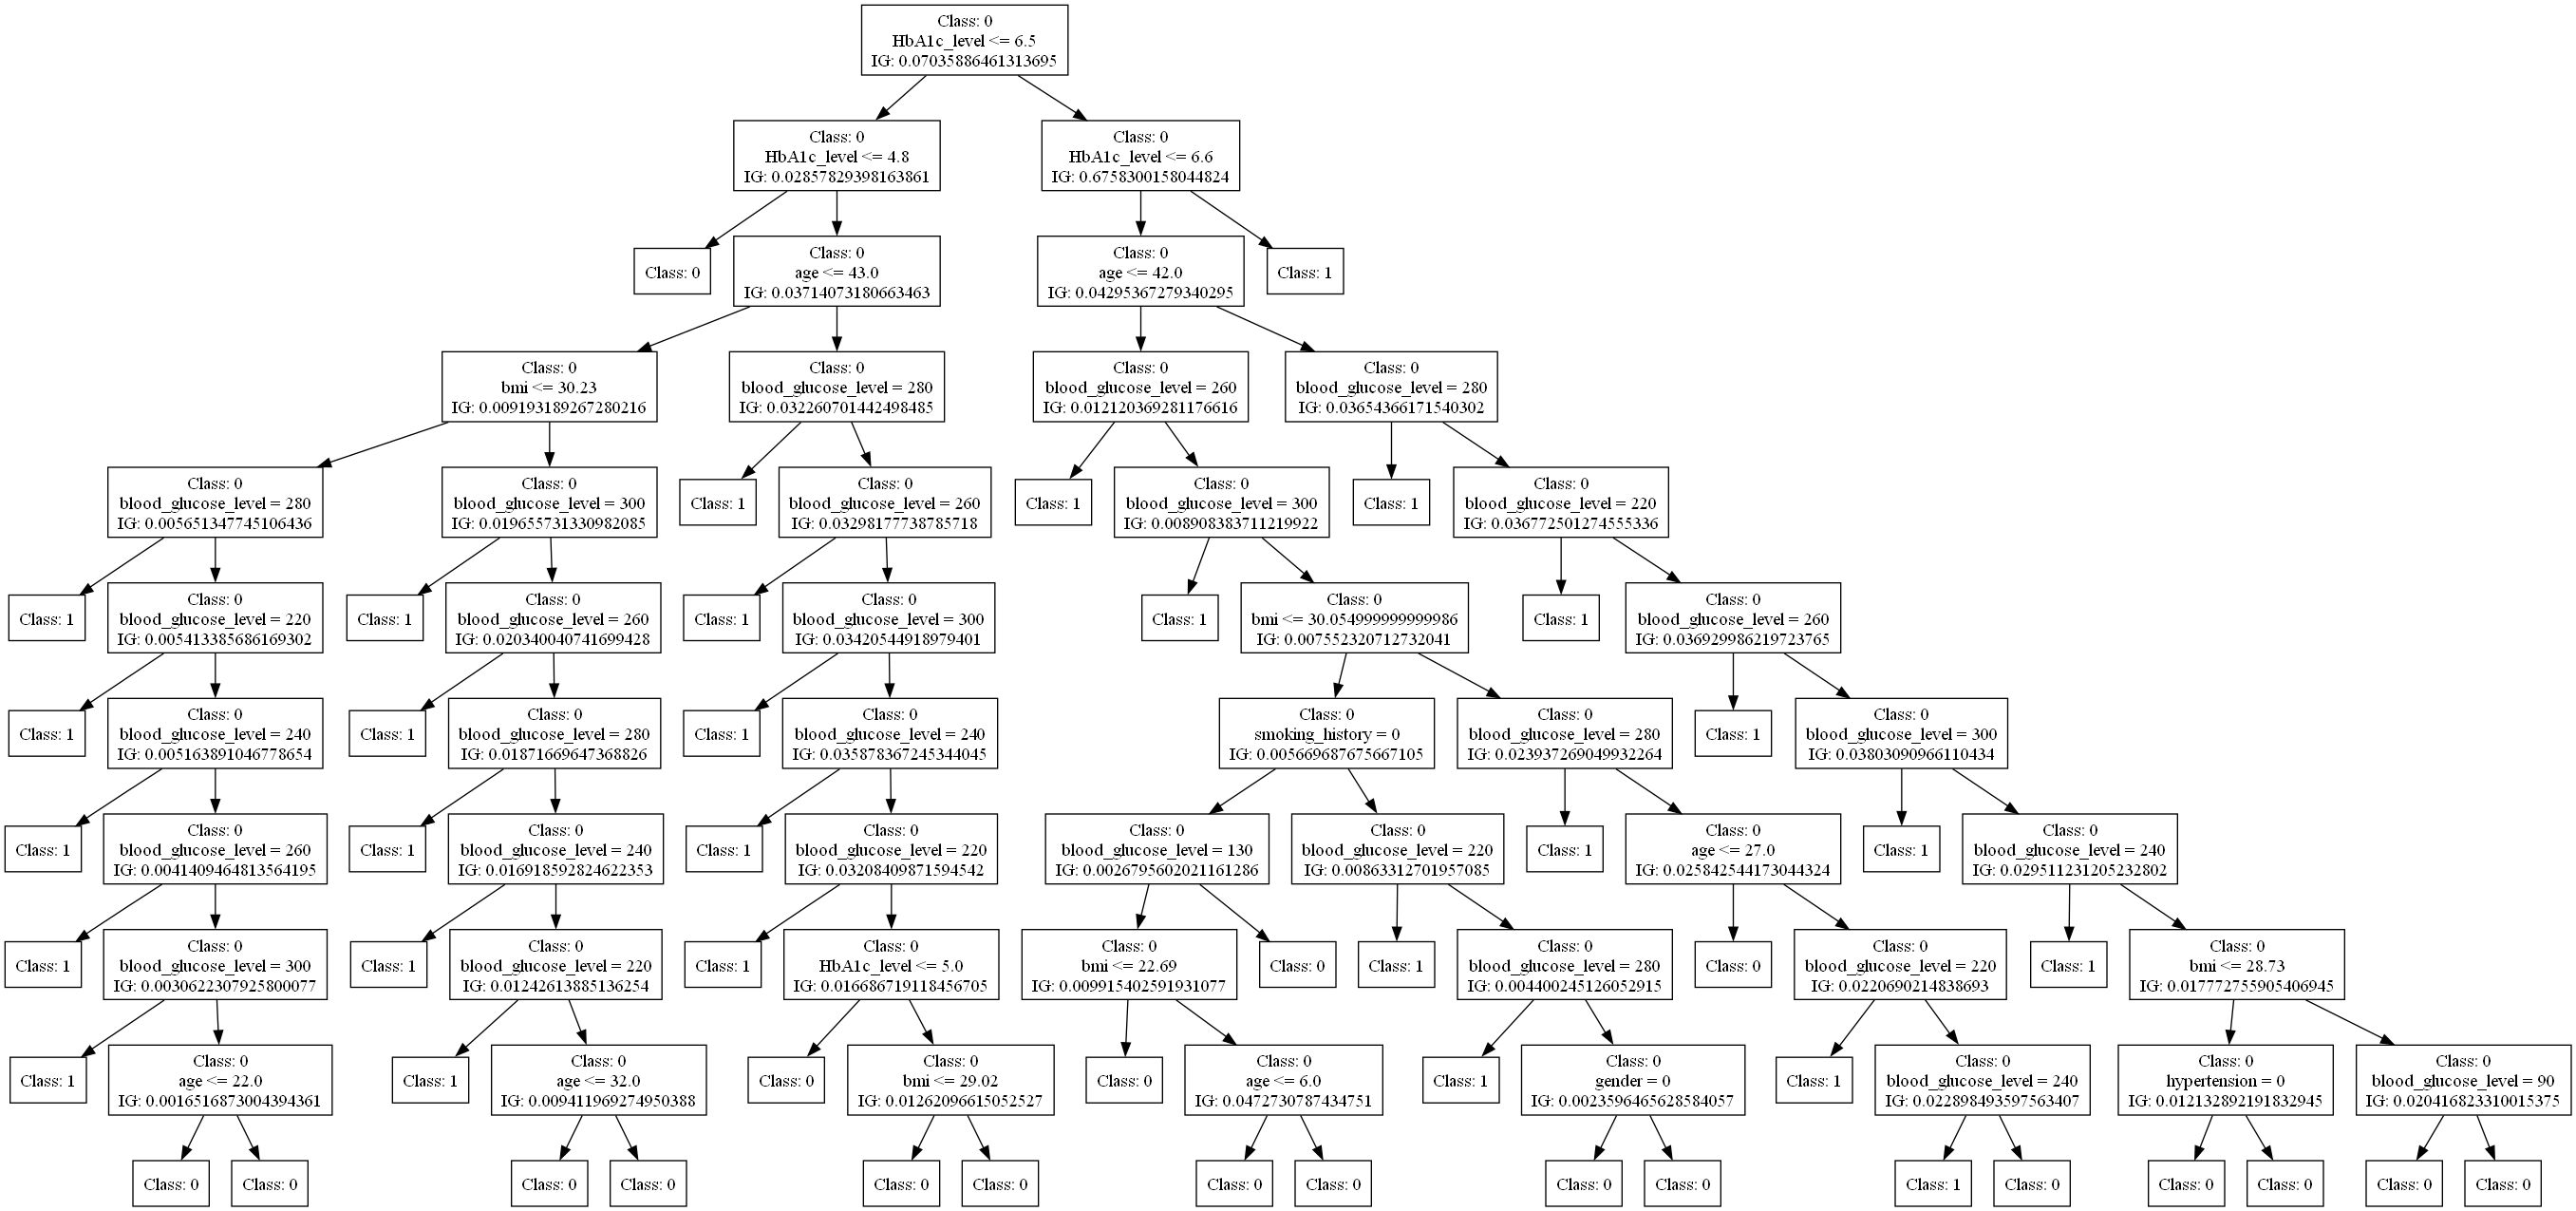

In [7]:
display(Image(filename='./dot_figs/tree-custom-diabetes.png'))

## IBM Money Laundering Dataset

In [8]:
original_df_train, original_df_test = get_train_and_test(hi_small_trans, verbose=VERBOSE)

print("Length of training set:", len(original_df_train), "    Length of test set:", len(original_df_test))

original_df_train.head()

Length of training set: 4062676     Length of test set: 1015669


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4205263,2022/09/08 23:03,70,100428A08,148586,8120D5550,13204.53,Saudi Riyal,13204.53,Saudi Riyal,Cash,0
3270156,2022/09/07 00:15,1132,80C50E4A0,28,80B7644F0,329.94,Mexican Peso,329.94,Mexican Peso,Credit Card,0
2669041,2022/09/05 18:41,70,1004288E8,32814,80C1FC0D0,54497.52,Mexican Peso,54497.52,Mexican Peso,Credit Card,0
262487,2022/09/01 00:03,210,8000A4B20,226548,809D2E6E0,6370.84,Canadian Dollar,6370.84,Canadian Dollar,ACH,0
2618957,2022/09/05 16:19,21,803F9CB00,9679,804679BD0,21376.33,Yen,21376.33,Yen,Cheque,0


In [9]:
split_timestamp(original_df_train)
split_timestamp(original_df_test)

original_df_train.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Date,Hour,Minute,Is Laundering
4205263,70,100428A08,148586,8120D5550,13204.53,Saudi Riyal,13204.53,Saudi Riyal,Cash,2022/09/08,23,3,0
3270156,1132,80C50E4A0,28,80B7644F0,329.94,Mexican Peso,329.94,Mexican Peso,Credit Card,2022/09/07,0,15,0
2669041,70,1004288E8,32814,80C1FC0D0,54497.52,Mexican Peso,54497.52,Mexican Peso,Credit Card,2022/09/05,18,41,0
262487,210,8000A4B20,226548,809D2E6E0,6370.84,Canadian Dollar,6370.84,Canadian Dollar,ACH,2022/09/01,0,3,0
2618957,21,803F9CB00,9679,804679BD0,21376.33,Yen,21376.33,Yen,Cheque,2022/09/05,16,19,0


In [10]:
original_df_train, _ = label_encoder(original_df_train, ['Date', 'Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format'])
original_df_test, _ = label_encoder(original_df_test, ['Date', 'Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format'])

### ID3

In [11]:
hp_n_thresholds_values = [2, 4, 6]

def id3_experiment(df_train, df_test, type):
    X_train, y_train = get_X_and_Y(df_train, verbose=VERBOSE)
    X_test, y_test = get_X_and_Y(df_test, verbose=VERBOSE)
    
    for hp_n_thresholds in hp_n_thresholds_values:
        print(f"\n\033[32mNumber of thresholds: {hp_n_thresholds} \033[0m")
        start_time = time.time()
        decision_tree: DecisionTreeID3 = DecisionTreeID3(max_depth=10, num_thresholds_numerical_attr=hp_n_thresholds)
        decision_tree.fit(X_train, y_train)
        end_time = time.time()
        decision_tree.create_dot_files(filename=f"tree-id3-{type}-{hp_n_thresholds}", generate_png=True, view=VIEW)
        print("PERFORMANCES: ")
        predictions = list(decision_tree.predict_test(X_test))
        
        calculate_performances(predictions, y_test, "id3", verbose=True)

        print(f"Fit time: {end_time - start_time} seconds")
        print(f"Predict time: {time.time() - end_time} seconds")


In [12]:
print("\nWithout preprocessing")
df_train, df_test = original_df_train, original_df_test
id3_experiment(df_train, df_test, "wo_preprocessing")


Without preprocessing

Number of thresholds: 2 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 2

PERFORMANCES: 
    F1 score: 0.000000     Accuracy: 0.998945
   Precision: 0.000000       Recall: 0.000000
          TP:        0           TN:  1014597
          FP:        0           FN:     1072
         TPR: 0.000000          FPR: 0.000000
Fit time: 190.17341113090515 seconds
Predict time: 121.06808662414551 seconds

Number of thresholds: 4 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 4

PERFORMANCES: 
    F1 score: 0.000000     Accuracy: 0.998933
   Precision: 0.000000       Recall: 0.000000
          TP:        0           TN:  1014585
          FP:       12           FN:     1072
         TPR: 0.000000          FPR: 0.000012
Fit time: 239.73966693878174 seconds
Predict time: 144.3217957019806 seconds

Number of thresholds: 6 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 6

PERFORMANCES: 
    F1 score: 0.001807     Accuracy: 0.998912
   Prec

In [13]:
print("\nPreprocessing: Undersampling")
df_train, df_test = original_df_train, original_df_test
df_train = undersampling(df_train, VERBOSE=False)
id3_experiment(df_train, df_test, "undersampling")


Preprocessing: Undersampling

Number of thresholds: 2 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 2

PERFORMANCES: 
    F1 score: 0.000485     Accuracy: 0.699764
   Precision: 0.000243       Recall: 0.069030
          TP:       74           TN:   710655
          FP:   303942           FN:      998
         TPR: 0.069030          FPR: 0.299569
Fit time: 0.6060004234313965 seconds
Predict time: 123.98304486274719 seconds

Number of thresholds: 4 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 4

PERFORMANCES: 
    F1 score: 0.000499     Accuracy: 0.720194
   Precision: 0.000251       Recall: 0.066231
          TP:       71           TN:   731408
          FP:   283189           FN:     1001
         TPR: 0.066231          FPR: 0.279115
Fit time: 0.7429699897766113 seconds
Predict time: 127.08859324455261 seconds

Number of thresholds: 6 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 6

PERFORMANCES: 
    F1 score: 0.000316     Accuracy: 0.738080

In [14]:
print("\nPreprocessing: Oversampling")
df_train, df_test = original_df_train, original_df_test
df_train = oversampling(df_train, VERBOSE=False)
id3_experiment(df_train, df_test, "oversampling")


Preprocessing: Oversampling

Number of thresholds: 2 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 2

PERFORMANCES: 
    F1 score: 0.000366     Accuracy: 0.725997
   Precision: 0.000184       Recall: 0.047575
          TP:       51           TN:   737322
          FP:   277275           FN:     1021
         TPR: 0.047575          FPR: 0.273286
Fit time: 125.7023913860321 seconds
Predict time: 124.9952142238617 seconds

Number of thresholds: 4 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 4

PERFORMANCES: 
    F1 score: 0.000316     Accuracy: 0.738230
   Precision: 0.000159       Recall: 0.039179
          TP:       42           TN:   749755
          FP:   264842           FN:     1030
         TPR: 0.039179          FPR: 0.261032
Fit time: 158.42022848129272 seconds
Predict time: 141.55979084968567 seconds

Number of thresholds: 6 
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 6

PERFORMANCES: 
    F1 score: 0.000316     Accuracy: 0.738271
  

### Custom

### C4.5


In [15]:

def c45_experiment(df_train, df_test, type):
    X_train, y_train = get_X_and_Y(df_train, verbose=VERBOSE)
    X_test, y_test = get_X_and_Y(df_test, verbose=VERBOSE)
    
    start_time = time.time()
    decision_tree = DecisionTreeC45()
    decision_tree.fit(X_train, y_train)
    end_time = time.time()
    decision_tree.create_dot_files(filename=f"tree-c45-{type}", generate_png=True, view=VIEW)
    print("PERFORMANCES: ")
    predictions = list(decision_tree.predict_test(X_test))
        
    calculate_performances(predictions, y_test, "c45", verbose=True)

    print(f"Fit time: {end_time - start_time} seconds")
    print(f"Predict time: {time.time() - end_time} seconds")


        

In [16]:
print("\nWithout preprocessing")
df_train, df_test = original_df_train, original_df_test
c45_experiment(df_train, df_test, "wo_preprocessing")


Without preprocessing
PARAMETERS:
	MAX DEPTH: 20

PERFORMANCES: 
    F1 score: 0.000000     Accuracy: 0.998945
   Precision: 0.000000       Recall: 0.000000
          TP:        0           TN:  1014597
          FP:        0           FN:     1072
         TPR: 0.000000          FPR: 0.000000
Fit time: 1667.7497913837433 seconds
Predict time: 120.27827978134155 seconds


In [17]:
print("\nPreprocessing: Undersampling")
df_train, df_test = original_df_train, original_df_test
df_train = undersampling(df_train, VERBOSE=False)
c45_experiment(df_train, df_test, "undersampling")


Preprocessing: Undersampling
PARAMETERS:
	MAX DEPTH: 20



Exception: Condition is None

In [18]:
print("\nPreprocessing: Oversampling")
df_train, df_test = original_df_train, original_df_test
df_train = oversampling(df_train, VERBOSE=False)
c45_experiment(df_train, df_test, "oversampling")


Preprocessing: Oversampling
PARAMETERS:
	MAX DEPTH: 20

PERFORMANCES: 
    F1 score: 0.000316     Accuracy: 0.738307
   Precision: 0.000159       Recall: 0.039179
          TP:       42           TN:   749834
          FP:   264763           FN:     1030
         TPR: 0.039179          FPR: 0.260954
Fit time: 2023.259460926056 seconds
Predict time: 114.50135540962219 seconds
